# 課題
タイタニック号の沈没は歴史上最も悪名高い船の難破事故の一つです。

1912 年 4 月 15 日、処女航海中、広く「沈まない」と思われていた RMS タイタニック号が氷山に衝突して沈没しました。残念ながら、乗船者全員を乗せられるだけの救命ボートがなかったため、乗客と乗組員 2,224 人のうち 1,502 人が死亡しました。

生き残るにはある程度の運の要素もあったが、一部の人々のグループは他の人々よりも生き残る可能性が高いようだ。

このチャレンジでは、乗客データ（名前、年齢、性別、社会経済階級など）を使用して、「どのような人が生き残る可能性が高いか」という質問に答える予測モデルを構築していただきます。

In [40]:
import numpy as np
import pandas as pd

# 特徴量エンジニアリングの判断のため
import matplotlib.pyplot as plt
import seaborn as sns

## データの読み込み

In [41]:
train = pd.read_csv('/workspace/train.csv')
test = pd.read_csv('/workspace/test.csv')
gender_submission = pd.read_csv('/workspace/gender_submission.csv')

In [42]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
data = pd.concat([train, test], sort=False)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
# PassengerId: 乗客ID
# Survived: 生存者
# Pclass: 乗客クラス
# Name: 名前
# Sex: 性別
# Age: 年齢
# SibSp: 同乗している兄弟/配偶者の数
# Parch: 同乗している親/子供の数
# Ticket: チケット番号
# Fare: 運賃
# Cabin: 客室番号
# Embarked: 乗船港

## 与えられたデータと目的変数の関係を探索する¶
特徴量エンジニアリングの前にEDAを行い、データを丁寧に観察し、適切な処理を講じる。

訓練データで目的変数との関係の確認と、予測性のに寄与する可能性のある仮説を見つける

### sex

<Axes: xlabel='Sex', ylabel='count'>

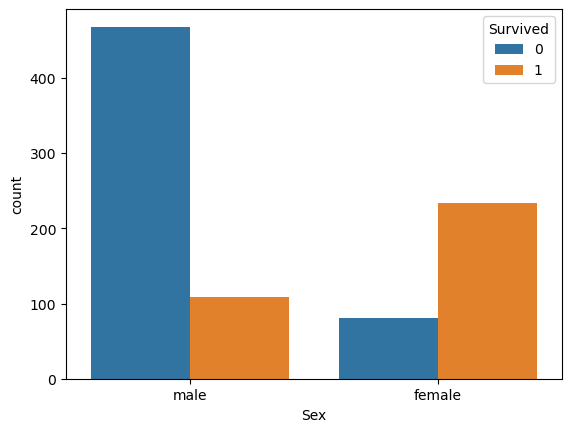

In [45]:
sns.countplot(x='Sex', hue='Survived', data=train)

男性は女性と比較して、生存している割合が低い。

性別によって生存率に大きな差があることがわかる。そのため、Sexは重要な特徴量となる。

### Age

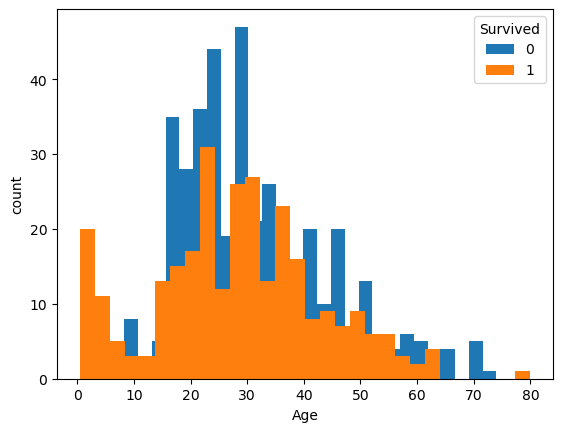

In [46]:
plt.hist(train.loc[train['Survived'] == 0, 'Age'], bins=30, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Age'], bins=30, label='1')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(title='Survived')

10代までの子ども、30代以降の生存率と比較し20代から30代の生存率が低いことがわかる。

### Fare(運賃)

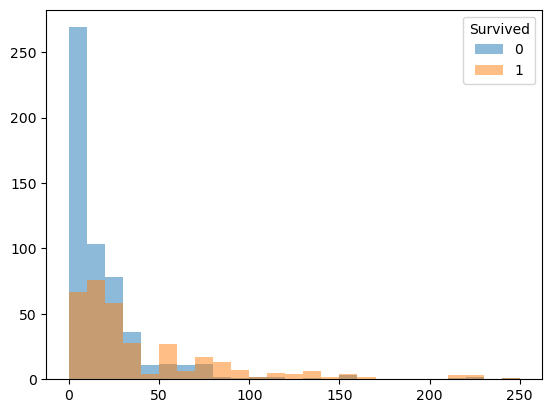

In [47]:
plt.hist(train.loc[train['Survived'] == 0, 'Fare'].dropna(),
         range=(0, 250), bins=25, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Fare'].dropna(),
         range=(0, 250), bins=25, alpha=0.5, label='1')
plt.legend(title='Survived')

運賃が30以下の乗客の生存率が低く、特に10以下の乗客は特に生存率が低いことがわかる。

### Pclass(乗客クラス)

<Axes: xlabel='Pclass', ylabel='count'>

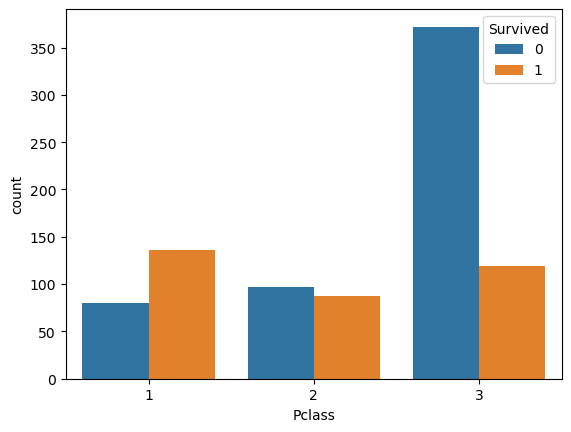

In [48]:
sns.countplot(x='Pclass', hue='Survived', data=train)

1から3にかけて生存率が低くなることがわかる。

### SibSp(同乗している兄弟/配偶者の数)

<Axes: xlabel='SibSp', ylabel='count'>

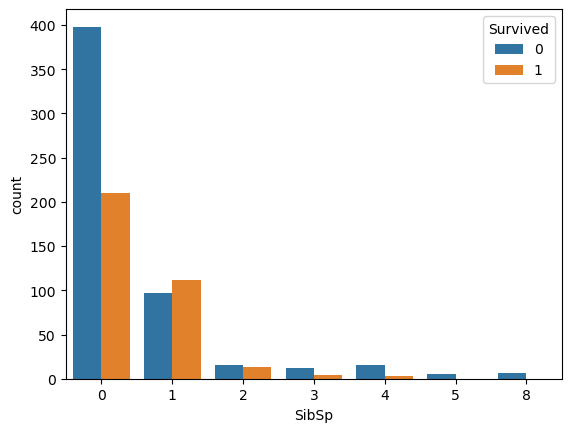

In [49]:
sns.countplot(x='SibSp', hue='Survived', data=train)

0と3以上のデータは生存率が低いことがわかる。

### Parch(同乗している親/子供の数)

<Axes: xlabel='Parch', ylabel='count'>

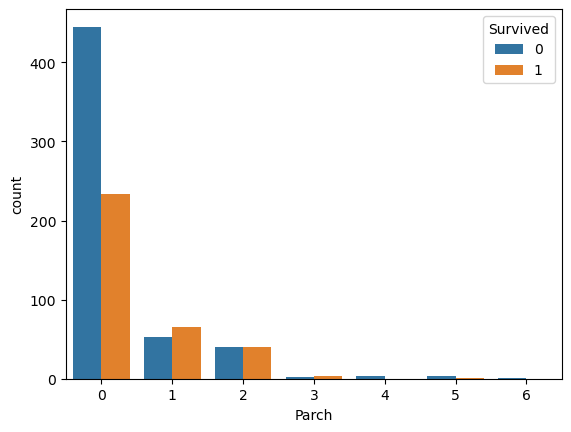

In [50]:
sns.countplot(x='Parch', hue='Survived', data=train)

0と4以上のデータが生存率が低いことが分かる。

### Embarked(乗船港)

<Axes: xlabel='Embarked', ylabel='count'>

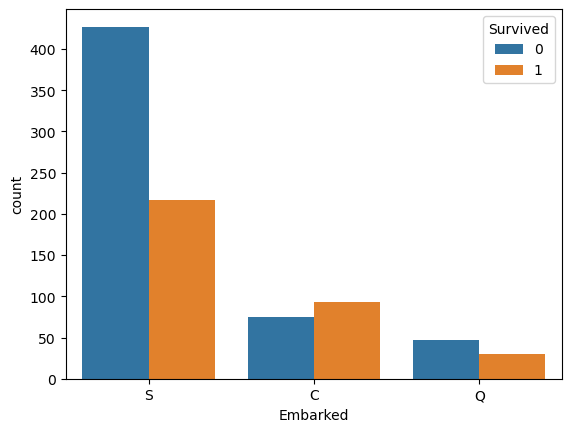

In [51]:
sns.countplot(x='Embarked', hue='Survived', data=train)

S,Qの生存率がCと比較して低いことがわかる。

### SibSpとParchを足し合わせたFamilySize（家族の人数）という特徴量を確認する

891
891
418
1309


<Axes: xlabel='FamilySize', ylabel='count'>

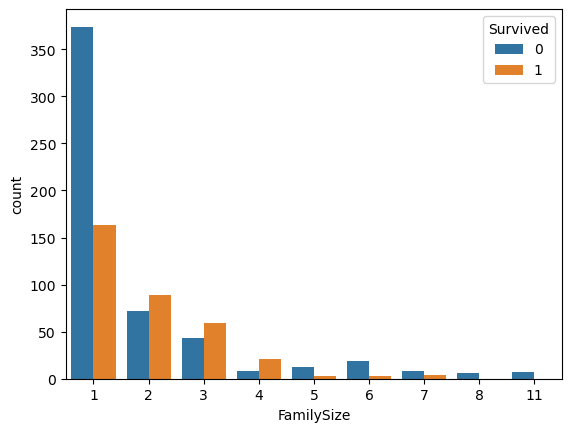

In [52]:
data['FamilySize'] = data['SibSp']+data['Parch']+1
print(len(train))
print(len(data['FamilySize'][:len(train)]))
print(len(data['FamilySize'][len(train):]))
print(len(data['FamilySize']))

# それぞれのデータに家族人数を追加。
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):].reset_index(drop=True)
sns.countplot(x='FamilySize', hue='Survived', data=train)

FamilySize >= 5の時、生存率が低いので、この特徴量は予測に寄与しそうだ。また、1人の割合が圧倒的に多く、また生存率も低いことから、特徴量に寄与しそうだ。

### 1人で乗船した乗客(IsAlone)の特徴量を確認する

IsAlone
1    790
0    519
Name: count, dtype: int64


<Axes: xlabel='IsAlone', ylabel='count'>

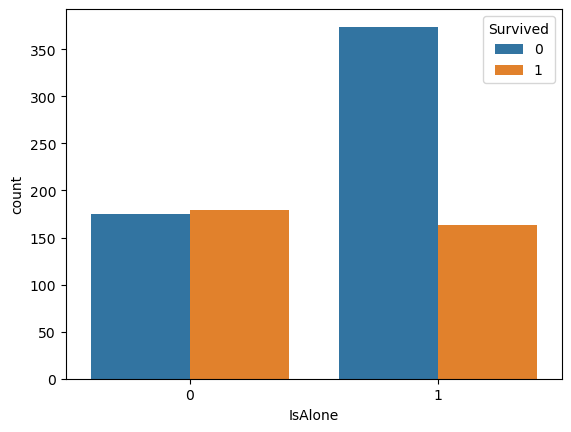

In [53]:
# 新しいカラムを作成し、デフォルトを０(1人ではない)とする
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):].reset_index(drop=True)

print(data['IsAlone'].value_counts())

sns.countplot(x='IsAlone', hue='Survived', data=train)

1人ではない乗客と比較して、1人の乗客の生存率が圧倒的に低いことが分かる。この特徴量は予測に寄与しそうだ。

## 特徴フィルタリング
* 読み込んだデータを機械学習アルゴリズムが扱える形に変換
* 既存のデータから、機械学習アルゴリズムが予測する上で有用な新しい特徴量を作成

### Sexのデータを補完

In [54]:
# Sexを数値データに変換。inplace = Trueはデータフレームの上書き。
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
data['Sex'].value_counts()

/tmp/ipykernel_1640/1182803865.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
/tmp/ipykernel_1640/1182803865.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)


Sex
0    843
1    466
Name: count, dtype: int64

### Fareのデータを補完

In [55]:
# 欠損値の補完。欠損値１のため、カラム内の平均値で補完する
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
data['Fare'].isna().sum()

/tmp/ipykernel_1640/420159703.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Fare'].fillna(np.mean(data['Fare']), inplace=True)


0

### Ageのデータを補完

(array([ 41.,  21.,  20.,  12.,  40.,  91., 109., 109.,  96., 119.,  66.,
         56.,  53.,  37.,  57.,  32.,  20.,  18.,  17.,  19.,   5.,   2.,
          3.,   2.,   1.]),
 array([ 0.17  ,  3.3632,  6.5564,  9.7496, 12.9428, 16.136 , 19.3292,
        22.5224, 25.7156, 28.9088, 32.102 , 35.2952, 38.4884, 41.6816,
        44.8748, 48.068 , 51.2612, 54.4544, 57.6476, 60.8408, 64.034 ,
        67.2272, 70.4204, 73.6136, 76.8068, 80.    ]),
 <BarContainer object of 25 artists>)

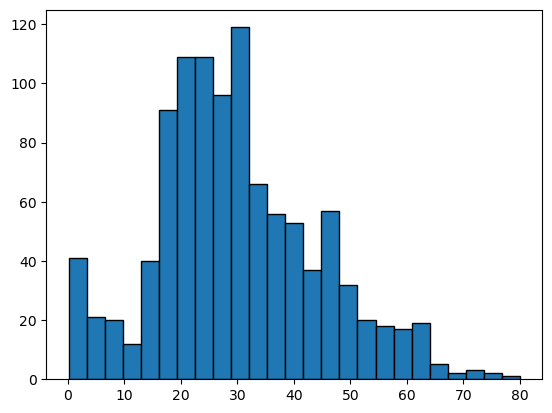

In [56]:
# Ageの分布を可視化で確認
plt.hist(data['Age'], bins=25, edgecolor='black')

In [57]:
# 平均値±標準偏差の中から乱数でデータを補完すると、再現性が担保されないため使うならSeed値を固定すること。
"""
age_avg = data['Age'].mean()  # 平均
age_std = data['Age'].std()   # 標準偏差
data['Age'].fillna(np.random.randint(age_avg - age_std,age_avg + age_std),inplace = True)
print(age_avg - age_std)
print(age_avg + age_std)
"""

# 今回は中央値で補完する。
print(data['Age'].mean())  # 平均値
print(data['Age'].median())  # 中央値
print(data['Age'].mode()[0])  # 最頻値
print(data['Age'].std())  # 標準偏差

data['Age'].fillna(data['Age'].median(), inplace=True)
data['Age'].isna().sum()

29.881137667304014
28.0
24.0
14.413493211271334


/tmp/ipykernel_1640/1417863789.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)


0

### Embarkedのデータを補完

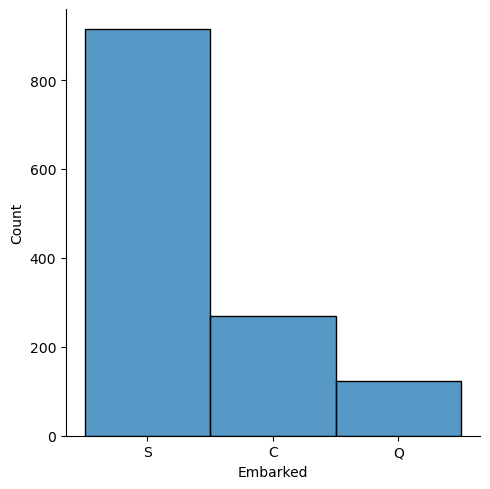

In [58]:
# Embarkedのデータの偏りを確認。
sns.displot(data['Embarked'])

In [59]:
# 欠損値の個数は２つと全体数に足して非常に小さい値なのでSで補完する
data['Embarked'].fillna('S', inplace=True)

# 文字列を数値データに変換。
# ロジスティック回帰に3種以上のデータは不向きだが最終的にlightGBMを機械学習アルゴリズムとして採用するためこの処理に着地
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

print(data['Embarked'].isna().sum())
print(data['Embarked'].value_counts())

0
Embarked
0    916
1    270
2    123
Name: count, dtype: int64


/tmp/ipykernel_1640/2940092159.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna('S', inplace=True)


## 特徴量の準備

In [60]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1


In [61]:
# これまでのEDAを経て、寄与しないデータを削除する
delete_column = ['PassengerId', 'Name', 'Ticket', 'Cabin']
data.drop(delete_column, axis=1, inplace=True)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,0.0,3,0,22.0,1,0,7.2500,0,2,0
1,1.0,1,1,38.0,1,0,71.2833,1,2,0
2,1.0,3,1,26.0,0,0,7.9250,0,1,1
3,1.0,1,1,35.0,1,0,53.1000,0,2,0
4,0.0,3,0,35.0,0,0,8.0500,0,1,1


In [62]:
# 学習データとテストデータの分割を行う
train = data[:len(train)]
test = data[len(train):]

print(len(train), len(test), len(data))

891 418 1309


In [63]:
# 目的変数（y）の抽出
y_train = train['Survived']

# 説明変数(X)の抽出
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

In [64]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,0,22.0,1,0,7.2500,0,2,0
1,1,1,38.0,1,0,71.2833,1,2,0
2,3,1,26.0,0,0,7.9250,0,1,1
3,1,1,35.0,1,0,53.1000,0,2,0
4,3,0,35.0,0,0,8.0500,0,1,1


特徴料の準備が完了。

## 機械学習アルゴリズム
用意した特徴量と予測の対象のペアから、機械学習アルゴリズムを用いて予測器を学習する。

In [65]:
# ロジスティック回帰という機械学習アルゴリズムを利用
from sklearn.linear_model import LogisticRegression

# モデルのインスタンス化
# 予測器の宣言。（ハイパーパラメータのチューニングは次回以降のKernelで試行錯誤する）
clf = LogisticRegression(penalty='l2', solver='sag', random_state=0)

In [66]:
# 予測器（モデル）の訓練
# clfに特徴量と予測の対象ペアを渡してfitさせることで学習を進める。
clf.fit(X_train, y_train)

# warning出ても訓練はできている。

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=0, solver='sag')

In [67]:
# 学習を終えた予測器は、未知の特徴量を与えて予測値をpredict(予測)させる

# ロジスティック回帰モデルによって予測された生存者のラベル
y_pred = clf.predict(X_test)

In [68]:
# 20個の予測値を取り出してみ
y_pred[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0.])

## 提出

In [72]:
# Notebook経由でsubmitするために予測値を提出ファイルの形式に整える
sub = gender_submission

# 整数に変換し、予測値に追加する
sub['Survived'] = list(map(int, y_pred))
sub.to_csv("/workspace/submission_1.csv", index=False)